In [10]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle

# DIR_NAME = "20250730_171659-plasma_flower"
DIR_NAME = "20250729_142821-spectra_flower"
IMG_SIZE = 1024
MAX_WIDTH = 16.0
LINSPACE_POINTS = 5

with open(f'results/{DIR_NAME}/shapes.pkl', 'rb') as f:
    shapes = pickle.load(f)

with open(f'results/{DIR_NAME}/shape_groups.pkl', 'rb') as f:
    shape_groups = pickle.load(f)

In [11]:
def bezier_curve(P0, P1, P2, t):
    """Quadratic Bezier curve."""
    return (1 - t) ** 2 * P0 + 2 * (1 - t) * t * P1 + t ** 2 * P2

def cubic_bezier_curve(P0, P1, P2, P3, t):
    """Cubic Bezier curve."""
    return (1 - t) ** 3 * P0 + 3 * (1 - t) ** 2 * t * P1 + 3 * (1 - t) * t ** 2 * P2 + t ** 3 * P3

diffvg_strokes = []
for i in range(len(shapes)):
    s = shapes[i].points.detach().cpu().numpy()
    stroke_width = shapes[i].stroke_width.detach().cpu().numpy()
    num_control_points = shapes[i].num_control_points.detach().cpu().numpy()
    color = shape_groups[i].stroke_color.detach().cpu().numpy()
    r, g, b, a = color

    pts = []
    idx = 0
    for seg in range(len(num_control_points)):
        n_ctrl = num_control_points[seg]
        if n_ctrl == 0:
            p0, p1 = s[idx:idx+2]
            pts.append(np.stack([p0, p1]))
            idx += 1
        elif n_ctrl == 1:
            p0, p1, p2 = s[idx:idx+3]
            t = np.linspace(0, 1, LINSPACE_POINTS)
            pts.append(bezier_curve(p0, p1, p2, t[:, None]))
            idx += 2
        elif n_ctrl == 2:
            p0, p1, p2, p3 = s[idx:idx+4]
            t = np.linspace(0, 1, LINSPACE_POINTS)
            pts.append(cubic_bezier_curve(p0, p1, p2, p3, t[:, None]))
            idx += 3

    pts = np.concatenate(pts, axis=0)
    diffvg_strokes.append({
        "color": color,
        "stroke_width": stroke_width,
        "points": pts,
    })

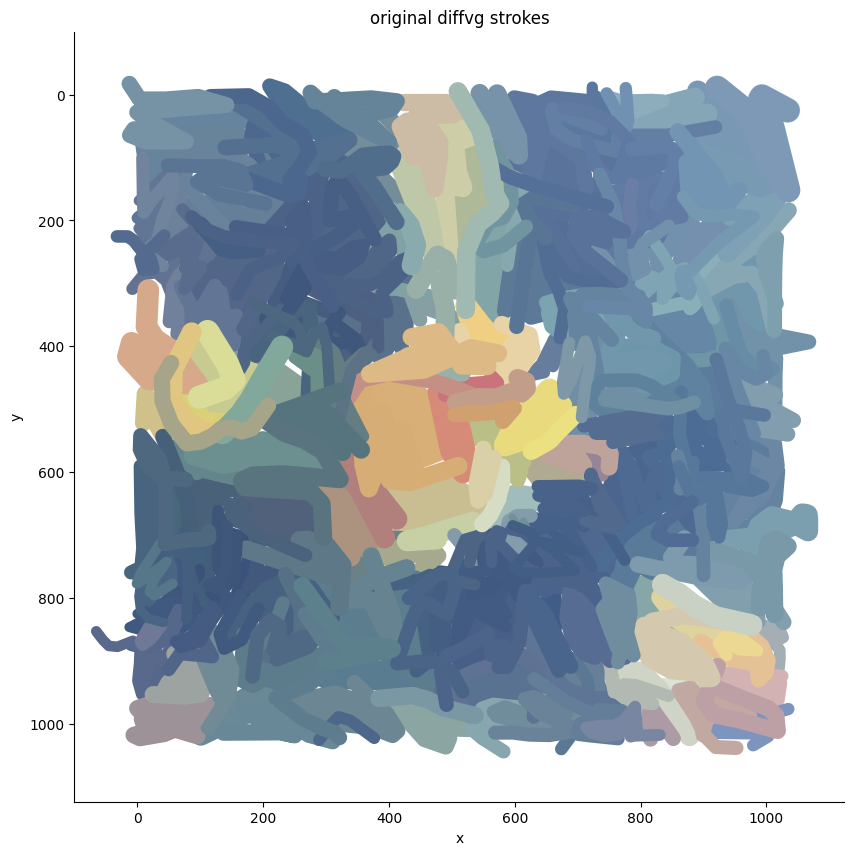

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
for stroke in diffvg_strokes:
    ax.plot(stroke["points"][:, 0], stroke["points"][:, 1], color=stroke["color"], linewidth=stroke["stroke_width"], solid_capstyle='round')
ax.invert_yaxis()
ax.set_xlim(-100, IMG_SIZE + 100)
ax.set_ylim(IMG_SIZE + 100, -100)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.set_title("original diffvg strokes")
plt.show()

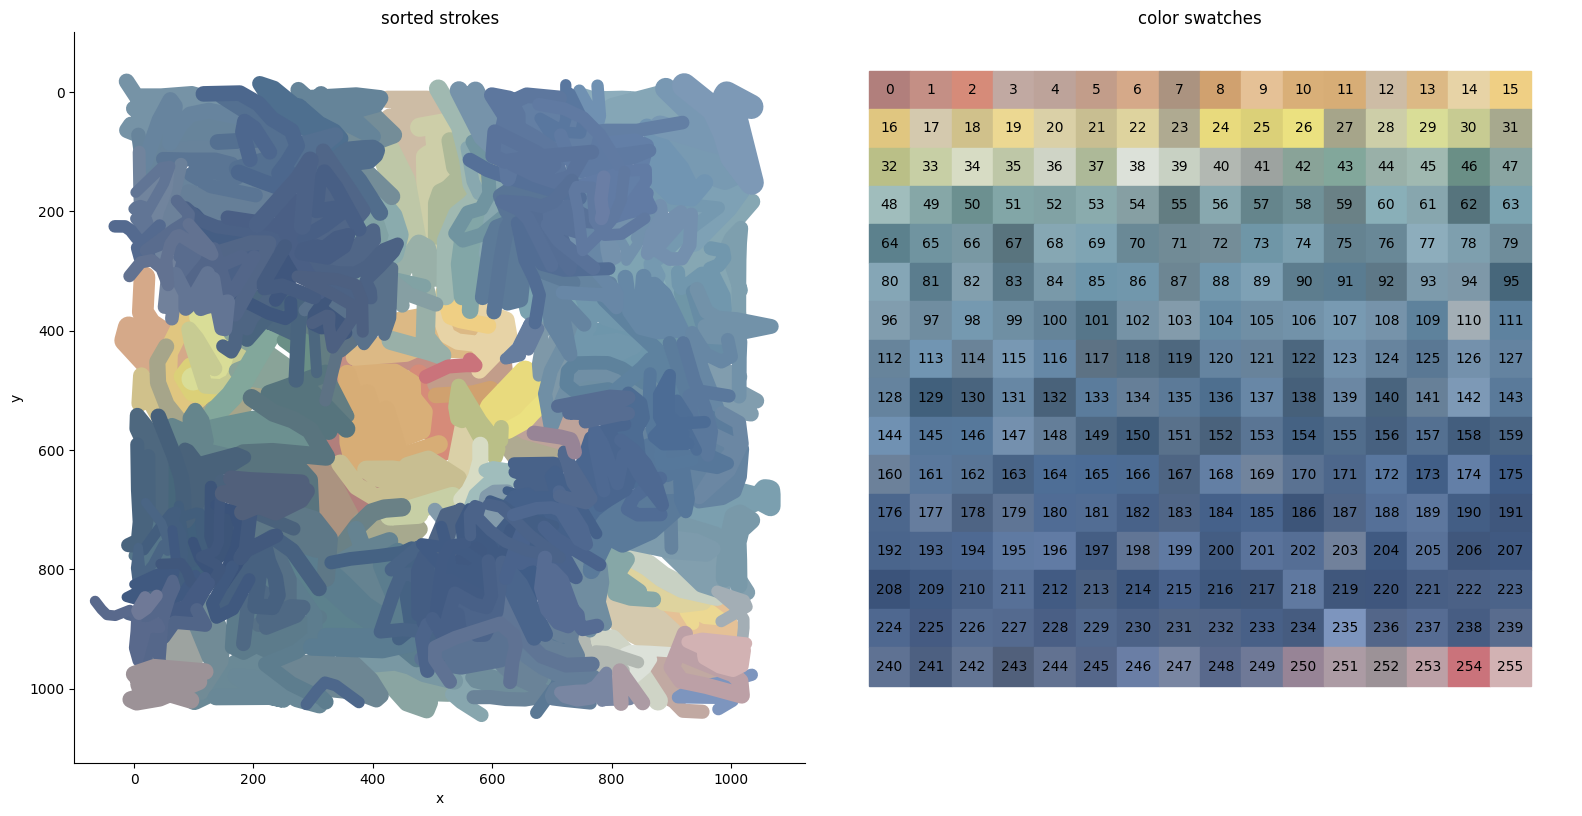

In [13]:
def color_sort_key_hue(color):
    """
    Sort primarily by hue, then by saturation and value.
    """
    import colorsys
    h, s, v = colorsys.rgb_to_hsv(color[0], color[1], color[2])
    return (h, s, v)

sorted_strokes = sorted(diffvg_strokes, key=lambda x: color_sort_key_hue(x["color"]), reverse=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# PLOT 1: SORTED STROKES
for stroke in sorted_strokes:
    ax1.plot(stroke["points"][:, 0], stroke["points"][:, 1], color=stroke["color"], linewidth=stroke["stroke_width"], solid_capstyle='round')
ax1.set_xlim(-100, IMG_SIZE + 100)
ax1.set_ylim(IMG_SIZE + 100, -100)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_aspect("equal")
ax1.set_title("sorted strokes")

# PLOT 2: SORTED SWATCHES
n = len(sorted_strokes)
swatch_w = 1.0
swatch_h = 1.0
cols = int(math.sqrt(n))
rows = n // cols + 1

for i, stroke in enumerate(sorted_strokes):
    row, col = i // cols, i % cols
    x, y = col, rows - 1 - row  # so first swatch is top-left
    rect = plt.Rectangle((x, y), 1.0, 1.0, color=stroke["color"])
    ax2.add_patch(rect)
    ax2.text(x + 0.5, y + 0.5, str(i), fontsize=10, ha="center", va="center")

ax2.set_xlim(-1, cols + 1)
ax2.set_ylim(-1, rows + 1)
ax2.axis("off")
ax2.set_title("color swatches")

plt.tight_layout()
plt.show()

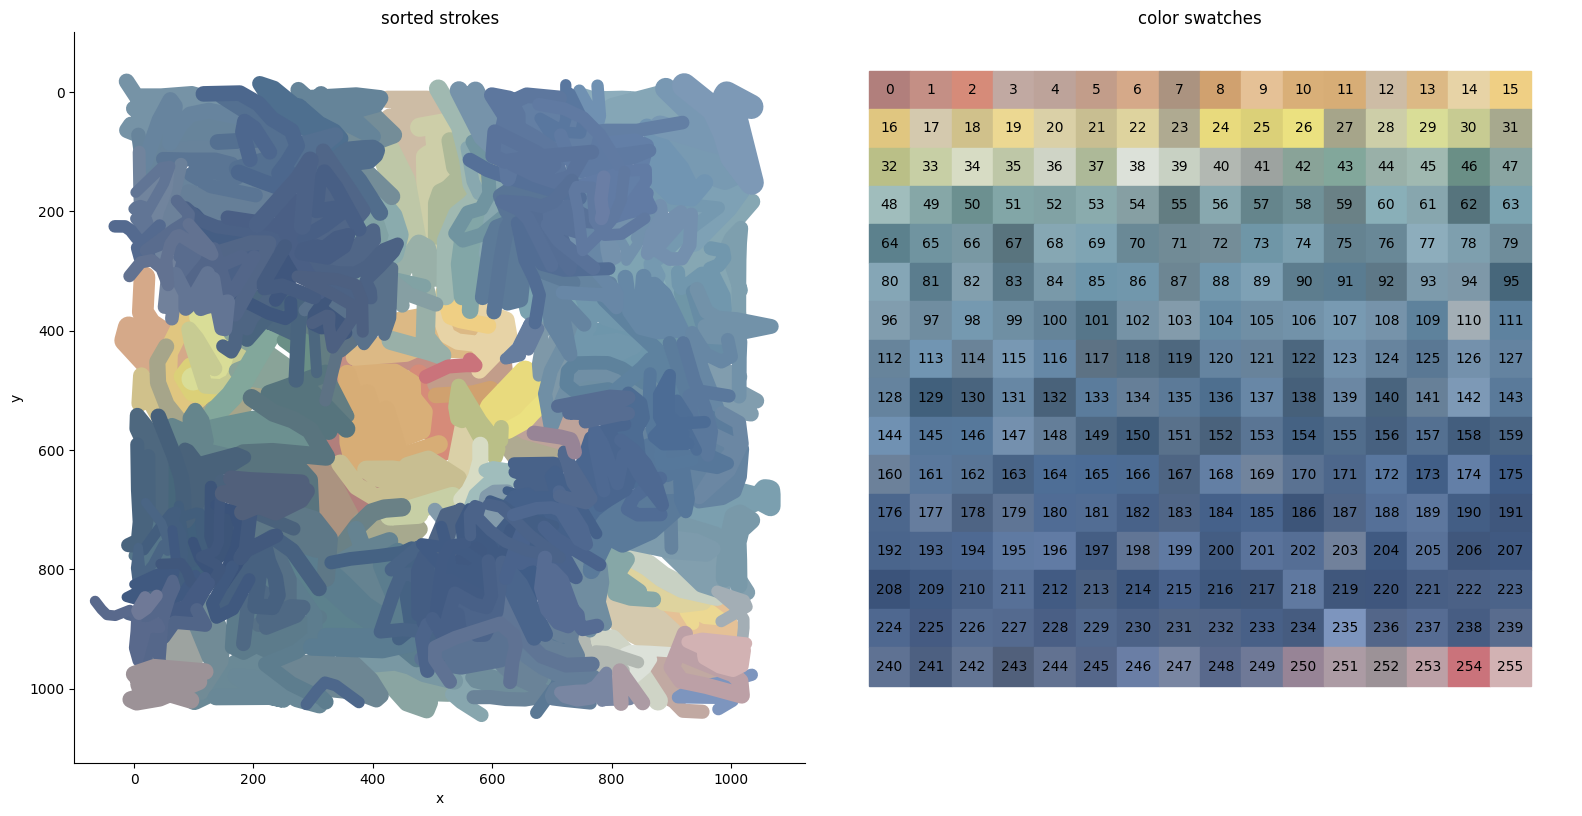

In [14]:
def color_sort_key_hue(color):
    """
    Sort primarily by hue, then by saturation and value.
    """
    import colorsys
    h, s, v = colorsys.rgb_to_hsv(color[0], color[1], color[2])
    return (h, s, v)

sorted_strokes = sorted(diffvg_strokes, key=lambda x: color_sort_key_hue(x["color"]), reverse=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# PLOT 1: SORTED STROKES
for stroke in sorted_strokes:
    ax1.plot(stroke["points"][:, 0], stroke["points"][:, 1], color=stroke["color"], linewidth=stroke["stroke_width"], solid_capstyle='round')
ax1.set_xlim(-100, IMG_SIZE + 100)
ax1.set_ylim(IMG_SIZE + 100, -100)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_aspect("equal")
ax1.set_title("sorted strokes")

# PLOT 2: SORTED SWATCHES
n = len(sorted_strokes)
swatch_w = 1.0
swatch_h = 1.0
cols = int(math.sqrt(n))
rows = n // cols + 1

for i, stroke in enumerate(sorted_strokes):
    row, col = i // cols, i % cols
    x, y = col, rows - 1 - row  # so first swatch is top-left
    rect = plt.Rectangle((x, y), 1.0, 1.0, color=stroke["color"])
    ax2.add_patch(rect)
    ax2.text(x + 0.5, y + 0.5, str(i), fontsize=10, ha="center", va="center")

ax2.set_xlim(-1, cols + 1)
ax2.set_ylim(-1, rows + 1)
ax2.axis("off")
ax2.set_title("color swatches")

plt.tight_layout()
plt.show()

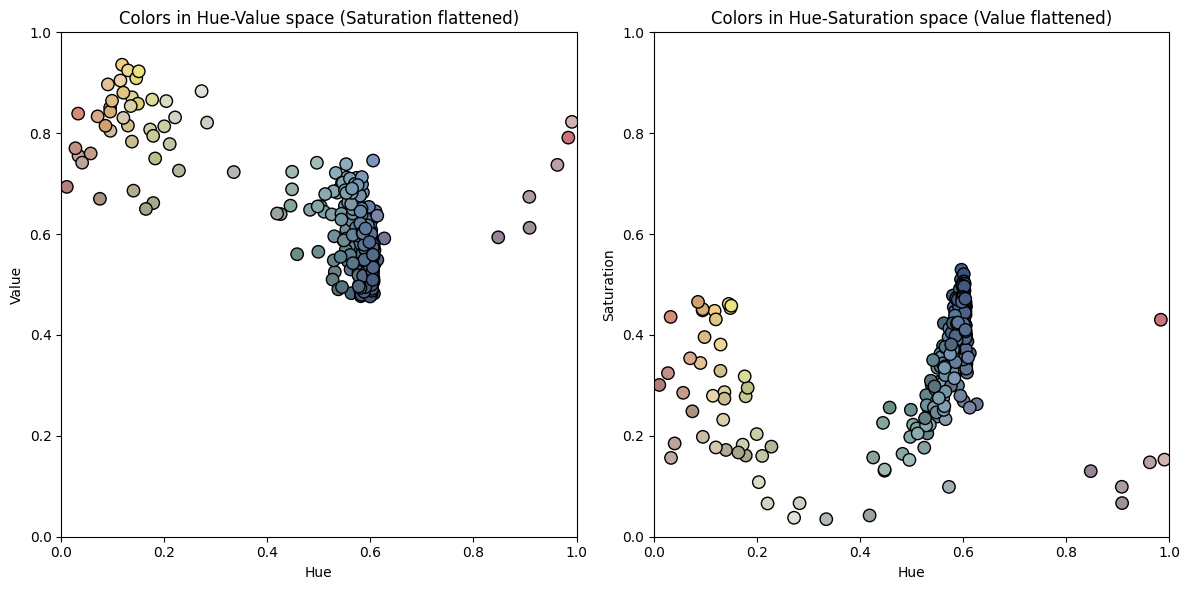

In [15]:
import numpy as np
import colorsys
import matplotlib.pyplot as plt

# Extract RGB colors
colors = [x["color"] for x in diffvg_strokes]

# Convert to HSV
hsv_colors = [colorsys.rgb_to_hsv(*color[:3]) for color in colors]
hsv_array = np.array(hsv_colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Hue vs Value (Saturation flattened)
h = hsv_array[:, 0]
v = hsv_array[:, 2]
rgb_array = np.array(colors)
ax1.scatter(h, v, c=rgb_array, s=80, edgecolor='k')
ax1.set_xlabel('Hue')
ax1.set_ylabel('Value')
ax1.set_title('Colors in Hue-Value space (Saturation flattened)')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot 2: Hue vs Saturation (Value flattened)
s = hsv_array[:, 1]
ax2.scatter(h, s, c=rgb_array, s=80, edgecolor='k')
ax2.set_xlabel('Hue')
ax2.set_ylabel('Saturation')
ax2.set_title('Colors in Hue-Saturation space (Value flattened)')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()


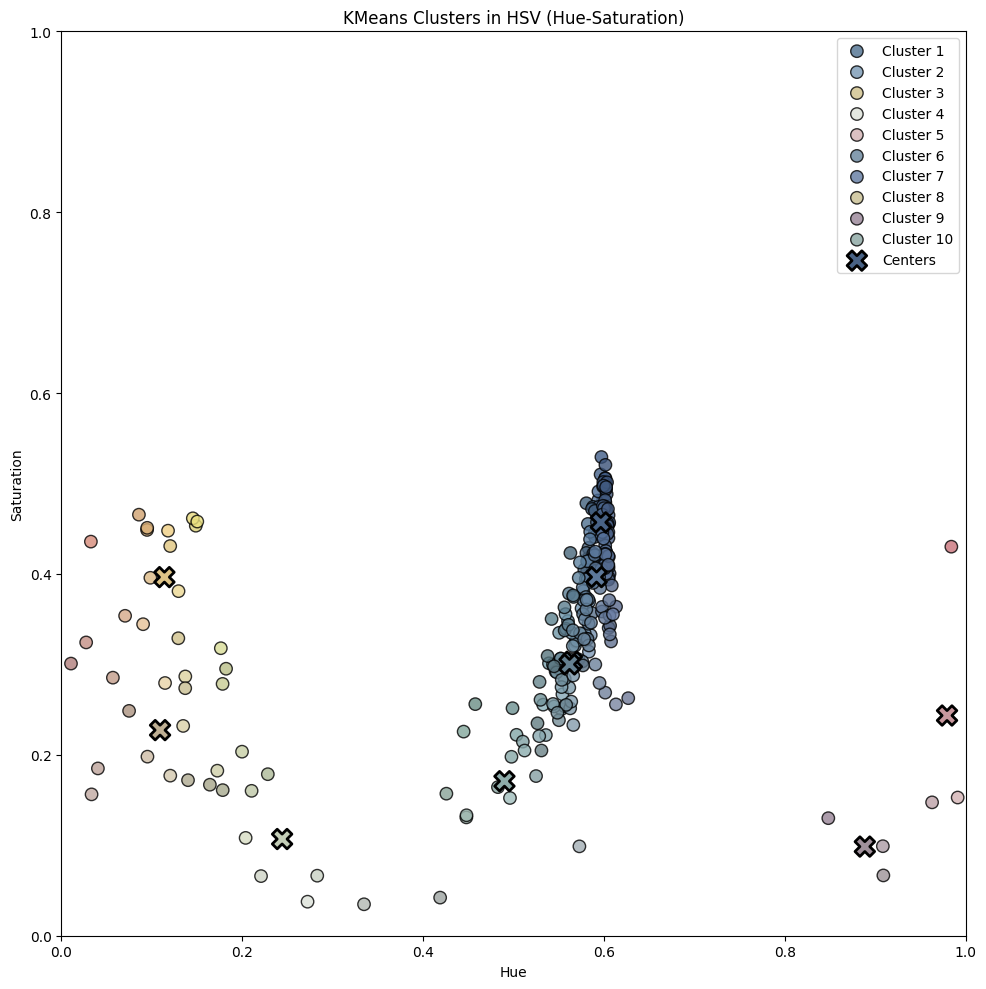

In [ ]:
import numpy as np
import colorsys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract RGB colors
colors = [x["color"] for x in diffvg_strokes]

# Convert to HSV
hsv_colors = [colorsys.rgb_to_hsv(*color[:3]) for color in colors]
hsv_array = np.array(hsv_colors)

# cluster in HSV space
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(hsv_array)

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(n_clusters):
    cluster_mask = labels == i
    ax.scatter(
        hsv_array[cluster_mask, 0],  # Hue
        hsv_array[cluster_mask, 1],  # Saturation
        color=rgb_array[cluster_mask],
        label=f'Cluster {i+1}',
        edgecolor='k',
        s=80,
        alpha=0.8
    )
# Mark cluster centers
centers = kmeans.cluster_centers_
ax.scatter(
    centers[:, 0], centers[:, 1],
    c=[colorsys.hsv_to_rgb(*center) for center in centers],
    marker='X',
    s=200,
    edgecolor='black',
    linewidth=2,
    label='Centers'
)
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_title('KMeans Clusters in HSV (Hue-Saturation)')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.legend()
plt.tight_layout()
plt.show()


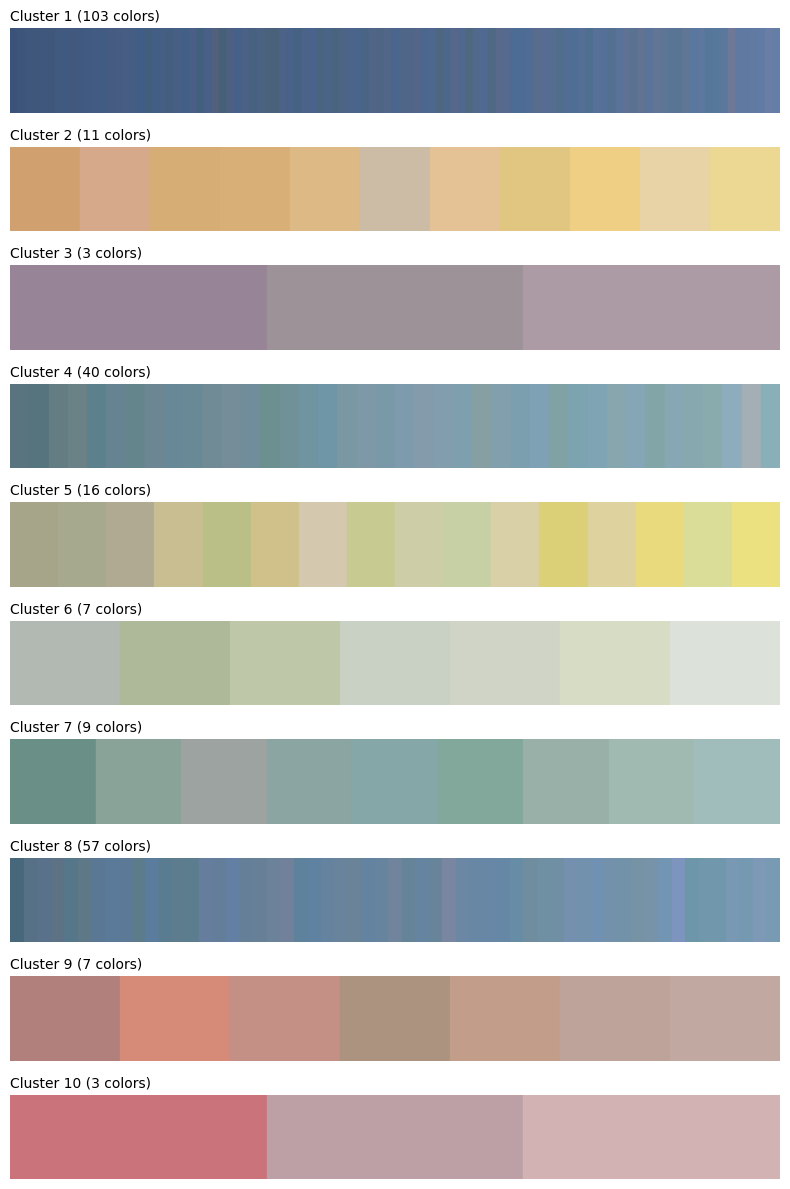

In [33]:
# cluster in HSV space, but emphasize hue more in clustering
n_clusters = 10

# Emphasize hue by scaling it up in the feature space
hue_weight = 5.0  # Increase this to emphasize hue more
hsv_weighted = hsv_array.copy()
hsv_weighted[:, 0] *= hue_weight  # Scale hue

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(hsv_weighted)

# Create a list displaying the colors in each cluster
clustered_colors = []
for i in range(n_clusters):
    cluster_colors = [colors[j] for j in range(len(colors)) if labels[j] == i]
    clustered_colors.append(cluster_colors)

# Visualize the colors in each cluster
fig, axes = plt.subplots(n_clusters, 1, figsize=(8, n_clusters * 1.2))
if n_clusters == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    cluster = clustered_colors[i]
    # sort cluster by saturation
    cluster.sort(key=lambda x: x[1])
    for j, color in enumerate(cluster):
        ax.add_patch(plt.Rectangle((j, 0), 1, 1, color=color))
    ax.set_xlim(0, max(1, len(cluster)))
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title(f'Cluster {i+1} ({len(cluster)} colors)', fontsize=10, loc='left')
plt.tight_layout()
plt.show()


In [ ]:
def width_to_pressure(width):
    return width * 6.5 / MAX_WIDTH

def transform_points(size, center, points, stroke_width):
    sx, sy = size
    cx, cy = center
    new_points = []

    for x, y in points:
        new_x = (x / IMG_SIZE - 0.5) * sx + cx
        new_y = -(y / IMG_SIZE - 0.5) * sy + cy
        pressure = width_to_pressure(stroke_width)
        new_points.append((new_x, new_y, pressure))
    return new_points

json_strokes = []
for stroke in sorted_strokes:
    hex_color = '#%02x%02x%02x' % tuple(int(c * 255) for c in stroke["color"][:3])
    json_strokes.append({
        "color": hex_color,
        "brush": 0,
        "speed": 10.0,
        "points": transform_points((36, 36), (12, -18), stroke["points"], stroke["stroke_width"])
    })

with open(f'results/{DIR_NAME}/strokes.json', 'w') as f:
    json.dump({"strokes": json_strokes}, f, indent=4)
